<a href="https://colab.research.google.com/github/nmermigas/PyTorch/blob/main/02_pytorch_neural_network_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. Neural Network classification with PyTorch

Classification is a problem of predicting whether somethinf is one thing or another (or multiclass)

# 1. Make classification data and get ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles

X, y = make_circles(n_samples,
                    noise = 0.03,
                    random_state = 42)

X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
 # make DataFrame of circle data

 import pandas as pd
 circles = pd.DataFrame({"X1": X[:,0],
                         "X2": X[:, 1],
                         "label": y})
 circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


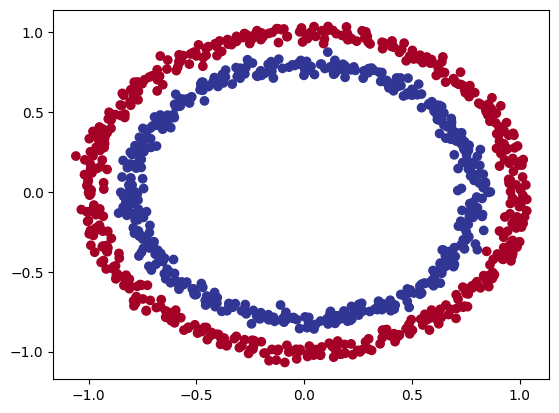

In [4]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap = plt.cm.RdYlBu)

In [5]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")


Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


### Turn data into tensors and create train and test splits

In [6]:
import torch
torch.__version__

'2.1.0+cu118'

In [7]:
type(X)

numpy.ndarray

In [8]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [9]:
X[:5],y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [10]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train,y_test = train_test_split(X,
                                                   y,
                                                   test_size = 0.2, # 20% of data will be test & 80% will be train
                                                   random_state = 42)


In [11]:
len(X_train),len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Building a model

Let's build a model to classify the blue and red dots.

To do so, we want to:

1. Setup device agnostic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop



In [12]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [13]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

Now we have setup device agnostic code, let's creaate a model that:

1. Subclasses `nn.Module` (almost all models in PyTorch subclass `nn.Module`)

2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data.

3. Define a `forward()` method that outlines the forward pass (or forward computation) of the model

4. Insantiate an instance of our model class and send it to the target `device`

In [14]:
# 1. Construct a model that subclasses nn.Module

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2,out_features = 5) # takes in 2 features and upscales it to 5 features
    self.layer_2 = nn.Linear(in_features = 5, out_features=1) # takes in 5 features from previous layer and outputs a single feature

  # 3. Define a forward() method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer_1(x)) # x -> layer_1 -> layer_2 -> output

# 4.  Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [15]:
# Let's replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
# Make predictions
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.7049, -0.4155],
                      [ 0.3698,  0.2719],
                      [ 0.5863, -0.0766],
                      [ 0.6587,  0.3509],
                      [-0.1643, -0.1293]], device='cuda:0')),
             ('0.bias',
              tensor([-0.0563,  0.0115, -0.7017, -0.6505, -0.4422], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1894,  0.3814, -0.0883,  0.3517, -0.0865]], device='cuda:0')),
             ('1.bias', tensor([-0.2960], device='cuda:0'))])

In [17]:
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n {untrained_preds[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions: 
 tensor([[-0.4931],
        [-0.2639],
        [-0.8125],
        [-0.4037],
        [-0.3659],
        [-0.2295],
        [ 0.0619],
        [ 0.0711],
        [-0.8308],
        [-0.2436]], device='cuda:0')


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example, for regression you might want MAE or MSE ( mean absolute error or mean squared error).

For classification you might want binary cross entropy or categorical cross entropy.

As a reminder, the loss function measures how *wrong* the model's predictions are.

And for optimizers, two of the most common and useful are SGD and Adam, however PyTorch has a lot of built in.

* For the loss function we're going to use `torch.nn.BCEWithLogitsLoss()`.


In [18]:
# Setup the loss function
# loss_fn = nn.BCELoss() # requires inputs to have gone through the sigmoid activation function prior to input to BCELoss

loss_fn = nn.BCEWithLogitsLoss() # has the sigmoid activation built in

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [19]:
# Calculate accuracy - out of 100 examples, what percentage does our model get right?

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train model

To train our model, we're going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step (gradient descent)

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification)

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.



In [20]:
# View the first 5 outputs of the forward pass on the test data
model_0.eval() # turn it into eval mode
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]
y_logits

# logits are the raw outputs of the model without being passed into activation functions. They are the unnormalized probabilities of the item belonging to a certain class.
# Logits are often used in classification tasks, where the goal is to predict the class label of an input.

tensor([[-0.4931],
        [-0.2639],
        [-0.8125],
        [-0.4037],
        [-0.3659]], device='cuda:0')

In [21]:
# Use the sigmoid activation function on the model's logits
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3792],
        [0.4344],
        [0.3074],
        [0.4004],
        [0.4095]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:

* `y_pred_probs` >= 0.5, `y=1` (class 1)
* `y_pred_probs` < 0.5, `y=0` (class 0)


In [22]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# in full (logits->pred probs-> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(),y_pred_labels.squeeze()))

#Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 0.], device='cuda:0')

### 3.2 Building a training and a testing loop

In [23]:
torch.manual_seed(42) # ensure reproducability
torch.cuda.manual_seed(42)

# set the number of epochs
epochs = 100

# Put the data to target device

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
  ### Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss/accuracy
  # loss = loss_fn(torch.sigmoid(y_logits), # nn.BCELoss expects prediction probabilities as input
  #                y_train)
  loss = loss_fn(y_logits, # nn.BCEWithLogitsLoss expects raw logits as input
                 y_train)
  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate test loss/acc
    test_loss= loss_fn(test_logits,
                       y_test)

    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    # Print

    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f} Test Loss: {test_loss:.5f}, Test acc: {test_acc}%")


Epoch: 0 | Loss: 0.72651 | Acc: 42.50000 Test Loss: 0.73175, Test acc: 39.0%
Epoch: 10 | Loss: 0.70427 | Acc: 47.00000 Test Loss: 0.71101, Test acc: 48.5%
Epoch: 20 | Loss: 0.69758 | Acc: 48.87500 Test Loss: 0.70425, Test acc: 48.5%
Epoch: 30 | Loss: 0.69541 | Acc: 50.25000 Test Loss: 0.70166, Test acc: 47.5%
Epoch: 40 | Loss: 0.69457 | Acc: 50.37500 Test Loss: 0.70039, Test acc: 48.5%
Epoch: 50 | Loss: 0.69415 | Acc: 50.50000 Test Loss: 0.69959, Test acc: 48.0%
Epoch: 60 | Loss: 0.69390 | Acc: 51.00000 Test Loss: 0.69900, Test acc: 47.5%
Epoch: 70 | Loss: 0.69372 | Acc: 51.37500 Test Loss: 0.69852, Test acc: 47.5%
Epoch: 80 | Loss: 0.69358 | Acc: 51.25000 Test Loss: 0.69813, Test acc: 47.5%
Epoch: 90 | Loss: 0.69347 | Acc: 51.37500 Test Loss: 0.69780, Test acc: 46.5%


## 4. Make predictrions and evaluate the model

From the metrics it looks like the model isn't learning anything...

So let's inspect by visualizing!

To do so, we are going to import a function called `plot_decision_boundary()` -https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [24]:
import requests
from pathlib import Path

# Download helper functions from the above repo

if Path('helper_function.py').is_file():
  print('helper_function.py already exists')
else:
  print('downloading helper_function.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py","wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary



downloading helper_function.py


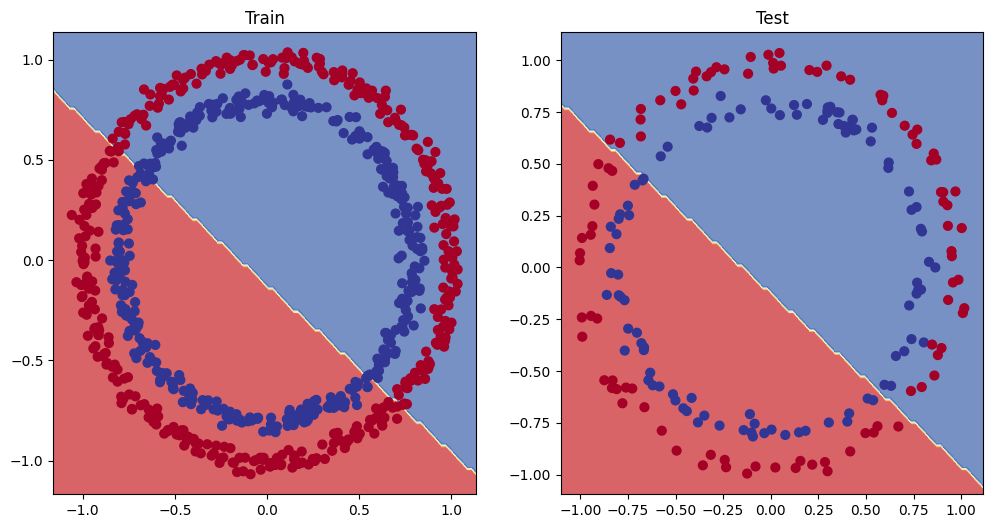

In [25]:
# Plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test,y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function

Let's try and improve thed model by:

* Adding more hidden units
* Increase the number of epochs
* Increase the number of layers

In [26]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 1,out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self,x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speed ups

model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=1, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

In [28]:
torch.manual_seed(42)

epochs = 1000 # Train for longer

# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> predicition probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # 2. Caculate loss/accuracy
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test,
                               y_pred=test_pred)

    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f} | Acc: {acc:.5f} Test Loss: {test_loss:.5f}, Test acc: {test_acc}%")


RuntimeError: ignored

## 6. The missing piece: **non-linearity**


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X,y = make_circles(n_samples,
                   noise = 0.03,
                   random_state = 42)

plt.scatter(X[:,0], X[:,1], c=y)

In [ ]:
# convert data to tensors and then train and test splits
import torch
from sklearn.model_selection import train_test_split

#Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    random_state = 42)

X_train[:5]
